# MATH 693A Advanced Numerical Methods: Computational Optimization HW 4
###  By: Will McGrath


In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Problem 1 
### Program that trust-region method using the Steihaug method (see Lecture 15 and/or Algorithm 7.2 in the text Numerical Optimization by Nocedal and Wright 2006). Choose $B_k$ to be the exact Hessian, and use it to minimize the function: $f(x) = 100(x_2 - x_1^2)^2 + (1 - x_1)^2$. 

### Use the tolerance $\epsilon = 10^{−6}$. $\| \nabla{f(x_k)} \|< 10^{-8}$ as the stopping criteria for your optimization algorithm. Use an initial trust region radius of 1. Set maximum trust region radius to 300. Use the initial point: $x_0 = [-1.2, 1]$ and then try another point $x_0 = [2.8, 4]$. Do the following for each of the initial points.

In [2]:
# Rosenbrock function
def objective_func(xbar_k):
    x = xbar_k[0]
    y = xbar_k[1]

    return 100*(y - x**2)**2 + (1 - x)**2

def gradient(xbar_k):
    x = xbar_k[0]
    y = xbar_k[1]

    return np.array([400*x**3 - 400*x*y + 2*x - 2, 200*(y - x**2)])

def hessian(xbar_k):
    x = xbar_k[0]
    y = xbar_k[1]
    
    return np.array([[1200*x**2 - 400*y + 2, -400*x],[-400*x, 200]])

## Part A

### Your program should indicate, at every iteration, whether Steihaug method encountered negative curvature, reached the trust-region boundary, or met the stopping test. Hand in your output.
> Note: Use Steihaug method to find pk and feed it into tr method

> Note: Quasi-Newton = just a different, modified hessian but methods are similar. The hessian doesn't have to be positive definite bc you can edit it to make it positive def or use a method that doesn't require it

### Tau Star

In [3]:
# compute tau star s.t. pbar_k = ||pbar_k + tau*dbar_k|| = trust_region
# simplifies to quadratic equation
def compute_tau_star(pbar_k, dbar_k, trust_reg):
    a_coeff = np.dot(dbar_k, dbar_k)
    b_coeff = 2 * np.dot(dbar_k, pbar_k)
    c_coeff = np.dot(pbar_k, pbar_k) - trust_reg**2

    # solve quadratic equation
    tau_1 = (-b_coeff + np.sqrt(b_coeff**2 - 4 * a_coeff * c_coeff)) / (2 * a_coeff) 
    tau_2 = (-b_coeff - np.sqrt(b_coeff**2 - 4 * a_coeff * c_coeff)) / (2 * a_coeff) 

    # conditions to choose tau star
    if tau_1 >= 0 and tau_2 < 0:
        return tau_1

    if tau_2 >= 0 and tau_1 < 0:
        return tau_2

    if tau_1 >= 0 and tau_2 >= 0:
        return min(tau_1, tau_2)

### Steihaug Method
- Quadratic convergence (i.e. $\epsilon = 10^{-6} \sim \| \nabla{f(x_k)} \| = \vert\vert \bar{x_k} - \bar{x}^* \vert\vert$ )

In [4]:
# trust_reg = delta
# eps = tolerance
# don't need Hk (Bk inverse or hessian inverse)
def steihaug_method(xbar_k, grad, Bk, trust_reg, eps=10**(-6)):
    pbar_k = [0, 0]
    rbar_k = grad(xbar_k) # residuals
    dbar_k = -rbar_k

    if np.linalg.norm(rbar_k) < eps:
        return pbar_k 

    while True:
        # negative curvature
        if np.dot(dbar_k, np.dot(Bk, dbar_k)) <= 0:
            tau_star = compute_tau_star(pbar_k, dbar_k, trust_reg)
            pbar_k = pbar_k + tau_star * dbar_k
            print('Negative curvature')

            return pbar_k
        
        alpha_k = np.dot(rbar_k, rbar_k) / np.dot(dbar_k, np.dot(Bk, dbar_k))
        pbar_kp1 = pbar_k + alpha_k * dbar_k

        # step outside trust region
        if np.linalg.norm(pbar_kp1) >= trust_reg:
            tau_star = compute_tau_star(pbar_k, dbar_k, trust_reg)
            pbar_k = pbar_k + tau_star * dbar_k
            print('Reached the trust region boundary')

            return pbar_k

        rbar_kp1 = rbar_k + alpha_k * np.dot(Bk, dbar_k)

        # stopping criteria
        if np.linalg.norm(rbar_kp1) <= (eps * np.linalg.norm(grad(xbar_k))): #(eps * np.linalg.norm(rbar_k)):
            print('Met stopping criteria')
            pbar_k = pbar_kp1
            
            return pbar_kp1
        
        # find Bk+1
        Bkp1 = np.dot(rbar_kp1, rbar_kp1) / np.dot(rbar_k, rbar_k)
        dbar_kp1 = -rbar_kp1 + np.dot(Bkp1, dbar_k)

        # set next iteration
        Bk = Bkp1
        dbar_k = dbar_kp1
        rbar_k = rbar_kp1
        pbar_k = pbar_kp1


### Trust Region
- Set $k = 1, \hat{\Delta} > 0, \Delta_0 \in (0, \hat{\Delta}),$ and $\eta \in (0, \frac{1}{4})$ S.T. $\hat{\Delta}$ = max trust region radius, and $\Delta_0$ = initial trust region radius
- Given a step $\bar{p_k}$ we define the ratio: $\rho_k=\frac{actual \ reduction}{predicted \ reduction} = \frac{f(\bar{x_k}) \ - \ f(\bar{x_k} + \bar{p_k})}{m_k(0) \ - \ m_k(\bar{p_k})}$
- If $\rho_k < 0$ We shrink the size of the trust region.
- If $\rho_k ≈ 0$ Then we shrink the size of the trust region.
- If $\rho_k ≈ 1$ Then the model is in good agreement with the objective; in this case it is (probably) safe to expand the trust region for the next iteration.
- Else we keep the size of the trust region.

In [91]:
# trust region algorithm 
def trust_region(x0, obj_func, grad, hess, grad_stop_criteria, eta=0.1, initial_trust_radius=1, max_trust_radius=300):
    xbar_k = x0 # xbar_k = xbar_transposed
    trust_reg = initial_trust_radius
    k = 1
    k_list, xbar_list, obj_func_xbar_list, pbar_list, rho_list, trust_reg_list = [], [], [], [], [], []

    while np.linalg.norm(grad(xbar_k)) > grad_stop_criteria:
        Bk = hess(xbar_k)
        
        # get approx. step pbar_k by steihaug method (gives minimized pbar_k)
        pbar_k = steihaug_method(xbar_k, grad, Bk, trust_reg)

        # define a ratio measuring the success of a step
        # given a step pbar_k we define the ratio: rho_k = actual reduction / predicted reduction 
        mk_0 = obj_func(xbar_k)
        mk_pbar_k = obj_func(xbar_k) + np.dot(grad(xbar_k),  pbar_k) + 0.5 * np.dot(pbar_k, np.dot(Bk, pbar_k))
        act_reduc = obj_func(xbar_k) - obj_func(xbar_k + pbar_k)
        pred_reduc = mk_0 - mk_pbar_k
        rho_k = act_reduc / pred_reduc

        # rho is close to zero or negative, therefore the trust region must shrink
        if rho_k < 0.25:
            trust_reg = 0.25 * trust_reg

        # rho is close to one and pbar_k has reached the boundary of the trust region, therefore the trust region must be expanded
        # euclidean norm of pbar_k = sqrt(np.dot(pbar_k, pbar_k)) = np.linalg.norm(pbar_k)
        else:
            if rho_k > 0.75 and np.linalg.norm(pbar_k) == trust_reg: #np.abs(np.linalg.norm(pbar_k) - trust_reg) < 10**(-8):
                trust_reg = min(2 * trust_reg, max_trust_radius)
        
        # add to dataframe
        if k == 1:
            xbar_list.append(x0)
            k_list.append(0)
            obj_func_xbar_list.append(obj_func(x0))
            pbar_list.append(np.nan)
            rho_list.append(np.nan)
            trust_reg_list.append(np.nan)

        # choose position for the next iteration
        if rho_k > eta:
            xbar_k = xbar_k + pbar_k
        else:
            xbar_k = xbar_k
        
        xbar_list.append(xbar_k)
        k_list.append(k)
        obj_func_xbar_list.append(obj_func(xbar_k))
        pbar_list.append(pbar_k)
        rho_list.append(rho_k)
        trust_reg_list.append(trust_reg)

        if k >= 23:
            break

        k = k + 1

        trust_region_steihaug_df = pd.DataFrame(
        [[k_list, xbar_list, obj_func_xbar_list, pbar_list, rho_list, trust_reg_list]], 
        columns=['iteration', 'xbar', 'f(xbar)', 'pbar', 'rho', 'trust_region']
    ).explode(['iteration', 'xbar', 'f(xbar)', 'pbar', 'rho', 'trust_region']).reset_index(drop=True)

    return trust_region_steihaug_df

In [102]:
# [-1.2, 1] = initial point in trust region
trust_region_steihaug_1_df = trust_region([-1.2, 1], objective_func, gradient, hessian, 10**(-8))
trust_region_steihaug_1_df

Reached the trust region boundary
Reached the trust region boundary
Reached the trust region boundary
Reached the trust region boundary
Reached the trust region boundary
Reached the trust region boundary
Reached the trust region boundary
Reached the trust region boundary
Reached the trust region boundary
Reached the trust region boundary
Reached the trust region boundary
Reached the trust region boundary
Reached the trust region boundary
Reached the trust region boundary
Reached the trust region boundary
Reached the trust region boundary
Reached the trust region boundary
Reached the trust region boundary
Reached the trust region boundary
Reached the trust region boundary
Reached the trust region boundary
Reached the trust region boundary
Reached the trust region boundary


,iteration,xbar,f(xbar),pbar,rho,trust_region
0,0,"[-1.2, 1]",24.2,NaN,NaN,NaN
1,1,"[-1.3960859479970613, 1.9805867126359065]",5.840647,"[-0.19608594799706133, 0.9805867126359064]",1.258742,1
2,2,"[-1.0649149777886238, 1.0370159476737855]",5.205316,"[0.33117097020843766, -0.9435707649621209]",0.282068,1
3,3,"[-0.6135173151752477, 0.1446930519756079]",7.972411,"[0.4513976626133761, -0.8923228956981776]",1.93459,2
4,4,"[-1.6273507483052456, 1.8686831244144964]",67.678613,"[-1.013833433129998, 1.7239900724388884]",1.132354,2
5,5,"[-1.9485592864359798, 3.842720883686572]",8.90411,"[-0.32120853813073413, 1.9740377592720755]",1.444895,2
6,6,"[-1.9485592864359798, 3.842720883686572]",8.90411,"[0.49003682818623323, -1.9390368503515285]",-0.425135,0.5
7,7,"[-1.833113055710489, 3.3562312457586128]",8.028188,"[0.11544623072549054, -0.48648963792795913]",0.883701,0.5
8,8,"[-1.6987598655138685, 2.8746201783151926]",7.29577,"[0.13435319019662073, -0.48161106744342025]",1.009618,1.0
9,9,"[-1.4120381939436841, 1.91660625198009]",6.414617,"[0.2867216715701843, -0.9580139263351025]",0.68211,1.0


In [103]:
# [-1.2, 1] = initial point in trust region
trust_region_steihaug_2_df = trust_region([2.8, 4], objective_func, gradient, hessian, 10**(-2))
trust_region_steihaug_2_df

Reached the trust region boundary
Reached the trust region boundary
Reached the trust region boundary
Reached the trust region boundary
Reached the trust region boundary
Reached the trust region boundary
Reached the trust region boundary
Reached the trust region boundary
Reached the trust region boundary
Reached the trust region boundary
Reached the trust region boundary
Reached the trust region boundary
Reached the trust region boundary
Reached the trust region boundary
Reached the trust region boundary
Reached the trust region boundary
Reached the trust region boundary
Reached the trust region boundary
Reached the trust region boundary
Reached the trust region boundary
Reached the trust region boundary
Reached the trust region boundary
Reached the trust region boundary


,iteration,xbar,f(xbar),pbar,rho,trust_region
0,0,"[2.8, 4]",1477.8,NaN,NaN,NaN
1,1,"[2.3761875232684533, 4.905749956978565]",56.730463,"[-0.4238124767315464, 0.905749956978565]",1.087693,1
2,2,"[2.426739178169948, 5.904471404723991]",2.059326,"[0.05055165490149502, 0.9987214477454263]",1.007129,2
3,3,"[2.426739178169948, 5.904471404723991]",2.059326,"[-0.4014276640080525, -1.9592998317177075]",-0.963536,0.5
4,4,"[2.3282549655976936, 5.4142664885164695]",1.768492,"[-0.0984842125722543, -0.4902049162075213]",0.897818,0.5
5,5,"[2.221474933858503, 4.925801520661274]",1.500372,"[-0.10678003173919035, -0.48846496785519583]",1.026688,1.0
6,6,"[1.9996574701008902, 3.9507133129733027]",1.228916,"[-0.22181746375761288, -0.975088207687971]",0.660708,1.0
7,7,"[1.7467517195708746, 2.983222392422185]",1.01894,"[-0.2529057505300155, -0.967490920551118]",3.700124,2.0
8,8,"[1.183645524348441, 1.0641310936815247]",11.382919,"[-0.5631061952224335, -1.9190912987406603]",3.083364,2.0
9,9,"[1.183645524348441, 1.0641310936815247]",11.382919,"[0.6009721835467507, 1.9075723930176411]",-0.394959,0.5


## Part B

### State the total number of iterations obtained in your optimization algorithm.

### The total number of iterations is 23. 

## Part C

### Plot the objective function $f(x)$. On the same figure, plot the $x_k$ values at the different iterates of your optimization algorithm.

In [104]:
def contourplot(objective_func, x_range, y_range, title, ncontours=500):
    xmin = x_range[0]
    xmax = x_range[1]
    ymin = y_range[0]
    ymax = y_range[1]

    # range of x and y 
    x = np.linspace(xmin, xmax, 100)
    y = np.linspace(ymin, ymax, 100)
    X, Y = np.meshgrid(x,y)
    xbar = [X,Y]
    Z = objective_func(xbar)

    plt.figure(figsize=(11, 7))
    plt.contour(X, Y, Z, ncontours, cmap = 'hsv'); # plot the contours
    plt.colorbar()
    plt.scatter(1, 1, marker="x", s=150, color="black", label = 'Minimum');  # mark the minimum
    plt.legend(loc=0)
    plt.title("Minimize $f(x,y)=100(y-x^2)^2 + (1-x)^2$ with %s"%title);
    plt.xlabel('x')
    plt.ylabel('y')

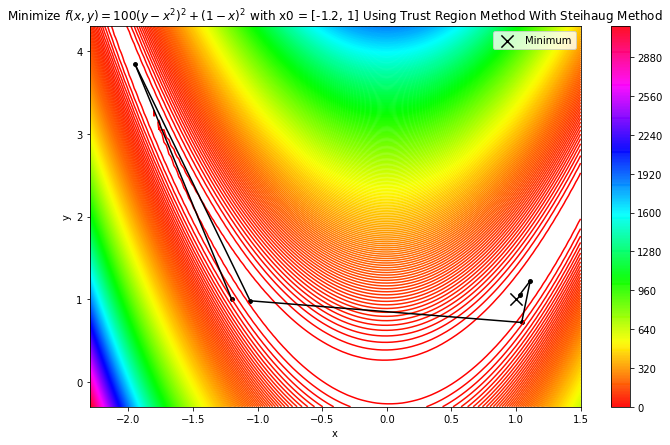

In [107]:
# plot objective function
contourplot(objective_func, [-2.3, 1.5], [-0.3, 4.3], "x0 = [-1.2, 1] Using Trust Region Method With Steihaug Method")

# plot random iterations
xbar_list_1 = trust_region_steihaug_1_df['xbar'].to_list()
pt1 = xbar_list_1[0]
pt2 = xbar_list_1[5]
pt3 = xbar_list_1[10]
pt4 = xbar_list_1[15]
pt5 = xbar_list_1[20]
pt6 = xbar_list_1[22]
all_pts = [pt1, pt2, pt3, pt4, pt5, pt6]

for pt in all_pts:
    plt.scatter(pt[0], pt[1], marker='o', s=15, color='black');

for i in range(1, len(all_pts)):
    plt.plot((all_pts[i-1][0], all_pts[i][0]), (all_pts[i-1][1], all_pts[i][1]), color='black');

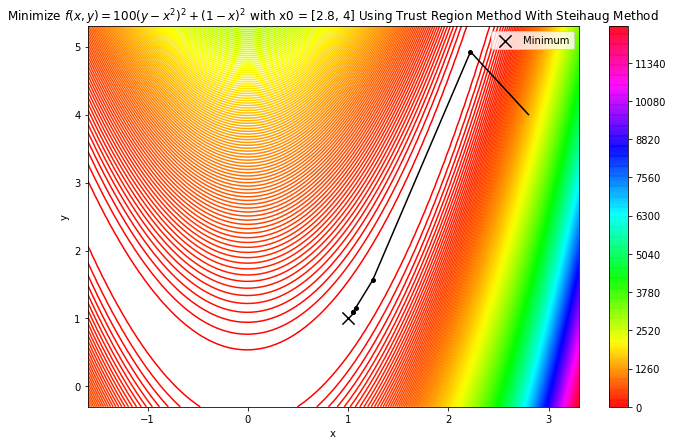

In [120]:
# plot objective function
contourplot(objective_func, [-1.6, 3.3], [-0.3, 5.3], "x0 = [2.8, 4] Using Trust Region Method With Steihaug Method")

# plot random iterations
xbar_list_2 = trust_region_steihaug_2_df['xbar'].to_list()
pt1 = xbar_list_2[0]
pt2 = xbar_list_2[5]
pt3 = xbar_list_2[10]
pt4 = xbar_list_2[15]
pt5 = xbar_list_2[20]
pt6 = xbar_list_2[22]
all_pts = [pt1, pt2, pt3, pt4, pt5, pt6]

for pt in all_pts:
    plt.scatter(pt[0], pt[1], marker='o', s=15, color='black');

for i in range(1, len(all_pts)):
    plt.plot((all_pts[i-1][0], all_pts[i][0]), (all_pts[i-1][1], all_pts[i][1]), color='black');

## Part D

### Plot the size of the objective function as a function of the iteration number. Use semi-log plot.

In [147]:
# semi-log plots
def plot_semilogy(xbar_list_1, xbar_list_2):
    indx_list_1 = np.linspace(1, len(xbar_list_1), len(xbar_list_1))
    indx_list_2 = np.linspace(1, len(xbar_list_2), len(xbar_list_2))
    a = [i[1] for i in xbar_list_1]
    b = [i[0] for i in xbar_list_2]

    plt.figure(figsize=(13, 8))
    plt.semilogy(indx_list_1, a, label="x0 = [-1.2, 1]");
    plt.semilogy(indx_list_2, b, label="x0 = [2.8, 4]");
    plt.xlabel('Iteration')
    plt.ylabel('Log of f(xbar)')
    plt.title('Algorithm Convergence')
    plt.xticks(np.arange(0,27))
    plt.legend(loc=0)

    return None

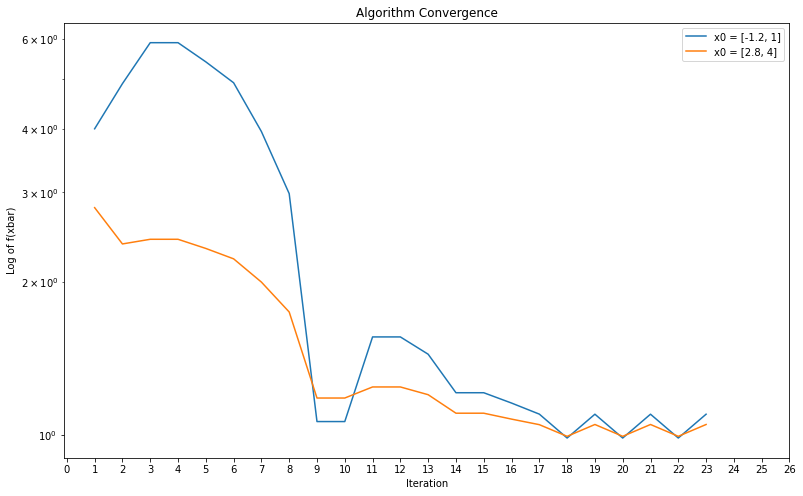

In [149]:
plot_semilogy(xbar_list_1, xbar_list_2)

## Part E

### Determine the minimizer of the function $x^*$.

### The minimizer for the function: $f(x) = 100(x_2 - x_1^2)^2 + (1 - x_1)^2$ is $x^* $ where $x^* = [1, 1]$. 

# Problem 2

### Implement the standard CG algorithm, and use it to solve linear systems in which A is the Hilbert matrix, whose elements are $\alpha_{ij} = 1 / (i + j - 1)$. Set the right-hand-side to be all ones $\vec{b} = ones(n,1)$, and the initial point to be the origin $\vec{x_o} = zeros(n,1)$. In the stopping criteria, use $\| \nabla{r_k)} \|> 10^{-6}$. 

### Using CG method uses only 6 iterations to find min. at n = 5
### CG takes at most $n^2$ iterations

In [109]:
# congujate gradient method
def linear_conjugate_gradient(A, b, x0, stopping_criteria = 10**(-6)):
    xk = x0
    rk = np.dot(A, xk) - b # residuals
    pk = -rk
    k = 0 # count 
    xk_list, rk_norm_list, residual_list, iteration_list = [], [], [], []

    while np.linalg.norm(rk) > stopping_criteria:
        
        ap_k = np.dot(A, pk) 
        rk_rk = np.dot(rk, rk)
        alpha = rk_rk / np.dot(pk, ap_k)

        if k == 0:
            iteration_list.append(k)
            residual_list.append(rk)
            xk_list.append(xk)
            rk_norm_list.append(np.linalg.norm(rk))

        xk = xk + alpha * pk
        rk = rk + alpha * ap_k
        beta = np.dot(rk, rk) / rk_rk
        pk = -rk + beta * pk

        k += 1
        iteration_list.append(k)
        residual_list.append(rk)
        xk_list.append(xk)
        rk_norm_list.append(np.linalg.norm(rk))

    df = pd.DataFrame([[iteration_list, xk_list, residual_list, rk_norm_list]], 
        columns=['iteration', 'xbar', 'residuals', 'norm_residuals']
    ).explode(['iteration', 'xbar', 'residuals', 'norm_residuals']).reset_index(drop=True)


    return df

In [110]:
# hilbert matrix
def hilbert(n):
    matrix = []
    for i in range(1, n + 1):
        row = []
        for j in range(1, n + 1):
            row.append(1 / (i + j - 1))
        matrix.append(row)
        
    return matrix

def bn(n):
    return np.ones(n)

def xn(n):
    return np.zeros(n)

In [111]:
# using CG method uses only 6 iterations to find min
# CG takes at most n^2 iterations
linear_conjugate_gradient(hilbert(5), bn(5), xn(5))

,iteration,xbar,residuals,norm_residuals
0,0,"[0.0, 0.0, 0.0, 0.0, 0.0]","[-1.0, -1.0, -1.0, -1.0, -1.0]",2.236068
1,1,"[0.7744314689612786, 0.7744314689612786, 0.774...","[0.7682851874615859, 0.12292562999385392, -0.1...",0.95224
2,2,"[-1.7325794320722485, 1.0239929628145126, 2.20...","[-0.09103425630351059, 0.16428356127873386, 0....",0.242068
3,3,"[2.720728486777693, -12.43586204808304, -2.780...","[0.0036731165348644346, -0.023085438173908485,...",0.042466
4,4,"[-3.8061193351162927, 45.65600430044791, -86.4...","[-5.4041639356890245e-05, 0.000771586686593349...",0.004676
5,5,"[5.000158216838807, -119.99990666966431, 630.0...","[0.0002477446770728287, 0.00014377996103980733...",0.000323
6,6,"[5.000000209720139, -120.0000000965577, 629.99...","[4.3717527939326345e-08, -2.0056173027861637e-...",0.0


## Part A

### For dimensions n = 5, 8, 12, 20, plot the norm of the residual as a function of the iteration (on the same figure); stop when the norm is less than $10^{-6}$. Use semi-log plot.

In [112]:
n5_df = linear_conjugate_gradient(hilbert(5), bn(5), xn(5))
n8_df = linear_conjugate_gradient(hilbert(8), bn(8), xn(8))
n12_df = linear_conjugate_gradient(hilbert(12), bn(12), xn(12))
n20_df = linear_conjugate_gradient(hilbert(20), bn(20), xn(20))

Text(0, 0.5, 'Residual Norm')

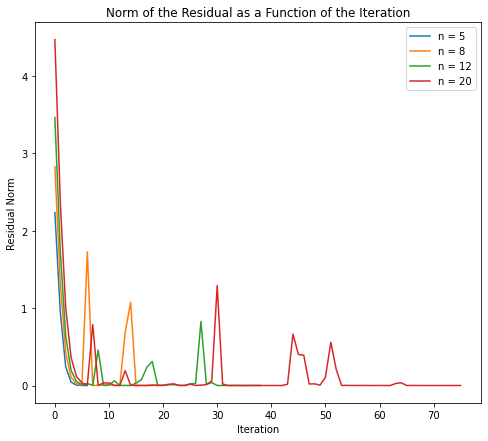

In [113]:
plt.figure(figsize=(8,7))
plt.plot(n5_df['iteration'].to_list(), n5_df['norm_residuals'].to_list(), label = 'n = 5')
plt.plot(n8_df['iteration'].to_list(), n8_df['norm_residuals'].to_list(), label = 'n = 8')
plt.plot(n12_df['iteration'].to_list(), n12_df['norm_residuals'].to_list(), label = 'n = 12')
plt.plot(n20_df['iteration'].to_list(), n20_df['norm_residuals'].to_list(), label = 'n = 20')
plt.legend(loc=0)
plt.title('Norm of the Residual as a Function of the Iteration')
plt.xlabel('Iteration')
plt.ylabel('Residual Norm')

Text(0, 0.5, 'Semi-Log of Residual Norm')

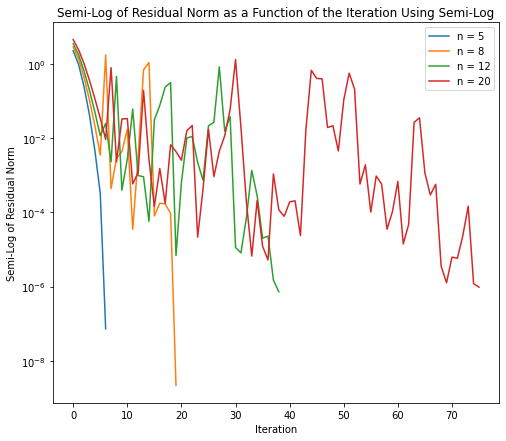

In [114]:
plt.figure(figsize=(8,7))
plt.semilogy(n5_df['iteration'].to_list(), n5_df['norm_residuals'].to_list(), label = 'n = 5')
plt.semilogy(n8_df['iteration'].to_list(), n8_df['norm_residuals'].to_list(), label = 'n = 8')
plt.semilogy(n12_df['iteration'].to_list(), n12_df['norm_residuals'].to_list(), label = 'n = 12')
plt.semilogy(n20_df['iteration'].to_list(), n20_df['norm_residuals'].to_list(), label = 'n = 20')
plt.legend(loc=0)
plt.title('Semi-Log of Residual Norm as a Function of the Iteration Using Semi-Log')
plt.xlabel('Iteration')
plt.ylabel('Semi-Log of Residual Norm')

Text(0, 0.5, 'Log of Residual Norm')

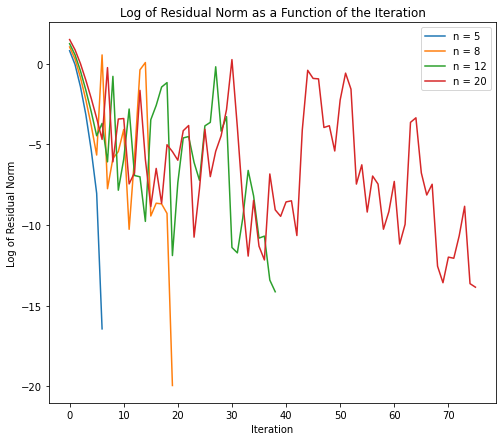

In [115]:
plt.figure(figsize=(8,7))
plt.plot(n5_df['iteration'].to_list(), np.log(n5_df['norm_residuals'].to_list()), label = 'n = 5')
plt.plot(n8_df['iteration'].to_list(), np.log(n8_df['norm_residuals'].to_list()), label = 'n = 8')
plt.plot(n12_df['iteration'].to_list(), np.log(n12_df['norm_residuals'].to_list()), label = 'n = 12')
plt.plot(n20_df['iteration'].to_list(), np.log(n20_df['norm_residuals'].to_list()), label = 'n = 20')
plt.legend(loc=0)
plt.title('Log of Residual Norm as a Function of the Iteration')
plt.xlabel('Iteration')
plt.ylabel('Log of Residual Norm')

## Part B

### Plot your number of iterations against n for n = 5, 8, 12, 20.

Text(0, 0.5, 'Iteration')

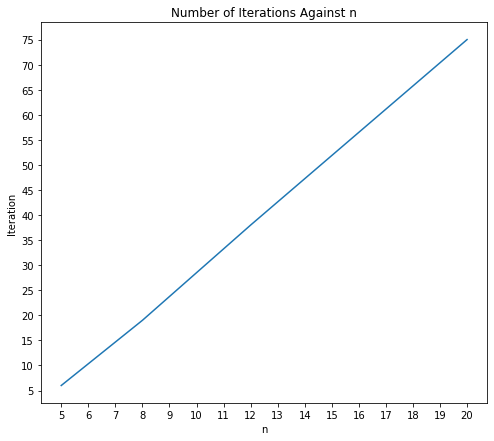

In [116]:
plt.figure(figsize=(8,7))
max_iteration_list = [max(n5_df['iteration'].to_list()), max(n8_df['iteration'].to_list()),
                     max(n12_df['iteration'].to_list()), max(n20_df['iteration'].to_list())]
                     
plt.plot([5, 8, 12, 20], max_iteration_list)
plt.title('Number of Iterations Against n')
plt.xticks(np.arange(5,21,1))
plt.xlabel('n')
plt.yticks(np.arange(5,80,5))
plt.ylabel('Iteration')

## Part C

### Compute the condition number for your Hilbert matrices, generate a plot of the condition number against the matrix size n. Use semi-log plot.
>Note: The Hilbert matrix shows up in the normal equations in least squares approximations and is an example of a matrix with a nasty condition number. Note that the Hilbert matrix is a square matrix, therefore a matrix size n denotes an 𝑛 × 𝑛 matrix.


>Note: The condition number of x is defined as the norm of x times the norm of the inverse of x [1]; the norm can be the usual L2-norm (root-of-sum-of-squares) or one of a number of other matrix norms.

Text(0, 0.5, 'Semi-Log of Condition Number')

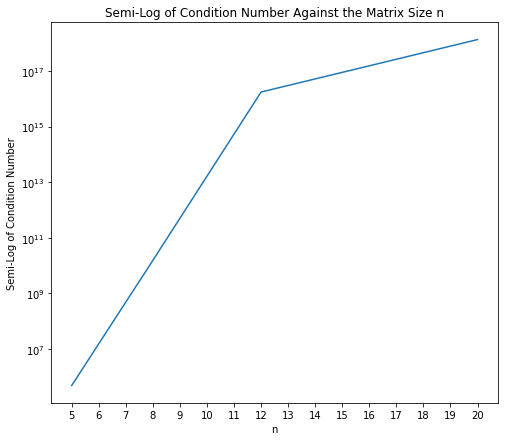

In [150]:
hilbert_matrix_list = [hilbert(n) for n in [5, 8, 12, 20]]
condition_list = [np.linalg.cond(a) for a in hilbert_matrix_list]

plt.figure(figsize=(8,7))
plt.semilogy([5, 8, 12, 20], condition_list)
plt.title('Semi-Log of Condition Number Against the Matrix Size n')
plt.xticks(np.arange(5,21,1))
plt.xlabel('n')
plt.ylabel('Semi-Log of Condition Number')

## Part D

### Plot the eigenvalues for n = 5, 8, 12, 20 on the same figure in order to show the spread of the eigenvalues.
>Note: An eigenvalue is a number, telling you how much variance there is in the data in that direction, in the example above the eigenvalue is a number telling us how spread out the data is on the line. The eigenvector with the highest eigenvalue is therefore the principal component. 

Text(0, 0.5, 'Eigenvalues')

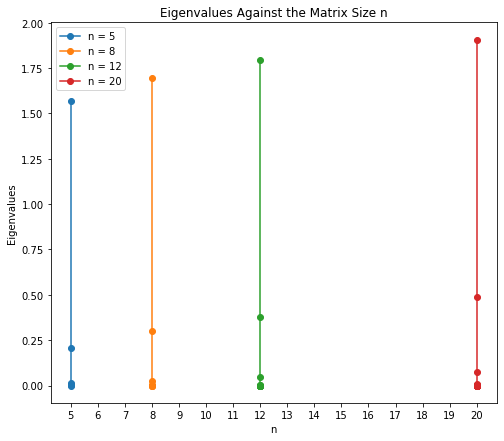

In [118]:
eigenvalue_list = [np.linalg.eig(e) for e in hilbert_matrix_list]
ones_list = [np.ones(n) * n for n in [5, 8, 12, 20]]

plt.figure(figsize=(8,7))
for i in range(len([5, 8, 12, 20])):
    plt.plot(ones_list[i], eigenvalue_list[i][0], marker='o')
plt.legend(['n = 5', 'n = 8', 'n = 12', 'n = 20'], loc=0);
plt.title('Eigenvalues Against the Matrix Size n')
plt.xticks(np.arange(5,21,1))
plt.xlabel('n')
plt.ylabel('Eigenvalues')

<ipython-input-119-4622ed6a3103>:3: RuntimeWarning: invalid value encountered in log
  plt.plot(ones_list[i], np.log(eigenvalue_list[i][0]), marker='o')


Text(0, 0.5, 'Log of Eigenvalues')

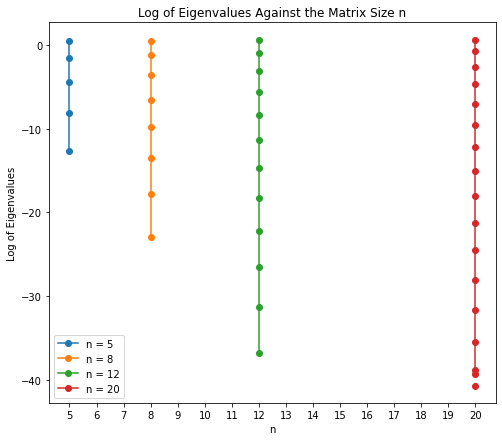

In [119]:
plt.figure(figsize=(8,7))
for i in range(len([5, 8, 12, 20])):
    plt.plot(ones_list[i], np.log(eigenvalue_list[i][0]), marker='o')
plt.legend(['n = 5', 'n = 8', 'n = 12', 'n = 20'], loc=0);
plt.title('Log of Eigenvalues Against the Matrix Size n')
plt.xticks(np.arange(5,21,1))
plt.xlabel('n')
plt.ylabel('Log of Eigenvalues')

## Part E

### From the formulas provided in the Lecture 11, estimate how many steepest descent iterations you would need to solve the problem to the same precision. What can you say about your estimate, is it a good estimate?

### For the Conjugate Gradient (CG) method: $\vert\vert \bar{x_k} - \bar{x}^* \vert\vert_A \le 2\left[\frac{\sqrt{K(A)} - 1}{\sqrt{K(A)} + 1} \right]^k \vert\vert \bar{x_0} - \bar{x}^* \vert\vert_A$, where $K(A) = \frac{\lambda_n}{\lambda_1} $. For Steepest Descent (SD) method: $\vert\vert \bar{x_{k+1}} - \bar{x}^* \vert\vert_A \le \begin{bmatrix} \frac{K(A) - 1}{K(A)+ 1} \end{bmatrix}^k \vert\vert \bar{x_0} - \bar{x}^* \vert\vert_A$, where $K(A) = \frac{\lambda_n}{\lambda_1}$. If we solve for k we get: 
## $ k \geq \frac{\ln\left(\frac{||\bar{x}_{k+1} - \bar{x}^*||_A}{||\bar{x}_{0} - \bar{x}^*||_A}\right)}{\ln\left(\frac{\kappa(A)-1}{\kappa(A)+1}\right)}$

### This means that if we want the same precision, $10^{-6}$, as the conjugate gradient method using the steepest descent method we would have $\sim \sqrt{K(A)}$ more iterations. 

### Resources
- [CG Method](https://towardsdatascience.com/complete-step-by-step-conjugate-gradient-algorithm-from-scratch-202c07fb52a8)